In [1]:
from typing import List, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import quantstats_lumi as qs
import requests
import math

from yfinance import tickers

import utils
import datetime

from tqdm import tqdm

sns.set_palette(sns.color_palette("hls", 12))

plt.style.use("ggplot")
STARTING_PERIOD = "2014-01-01"

In [2]:
data = pd.read_excel("portfolio_tickers.xlsx")

previousClose = []
marketCap = []
shares = []

for stock in tqdm(data["ticker"]):
    ticker = yf.Ticker(stock)
    previousClose.append(ticker.fast_info["previousClose"])
    marketCap.append(ticker.fast_info["marketCap"])
    shares.append(ticker.fast_info["shares"])
        
data["previousClose"] = previousClose
data["marketCap"] = marketCap
data["shares"] = shares
data.sort_values(by=["sector", "marketCap"], ascending=[True, False], inplace=True, ignore_index=True)

returns_data = yf.download(tickers=list(data["ticker"]), actions=True).loc[STARTING_PERIOD:]
returns_data.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

avg_return = []
yearly_return = []
volatility = []
max_drawdown = []

for ticker in tqdm(data["ticker"]):
    ret_series = utils.compute_returns(returns_data[("Adj Close", ticker)]).dropna()
    
    avg_return.append(ret_series.mean())
    volatility.append(qs.stats.volatility(ret_series))
    max_drawdown.append(qs.stats.max_drawdown(ret_series))
    yearly_return.append(utils.compute_yearly_compounded_returns(ret_series, prices=False))
    
data["avg_return"] = avg_return
data["yearly_return"] = yearly_return
data["volatility"] = volatility
data["max_drawdown"] = max_drawdown

100%|██████████| 20/20 [00:06<00:00,  3.32it/s]
[*********************100%%**********************]  20 of 20 completed
100%|██████████| 20/20 [00:00<00:00, 27.31it/s]


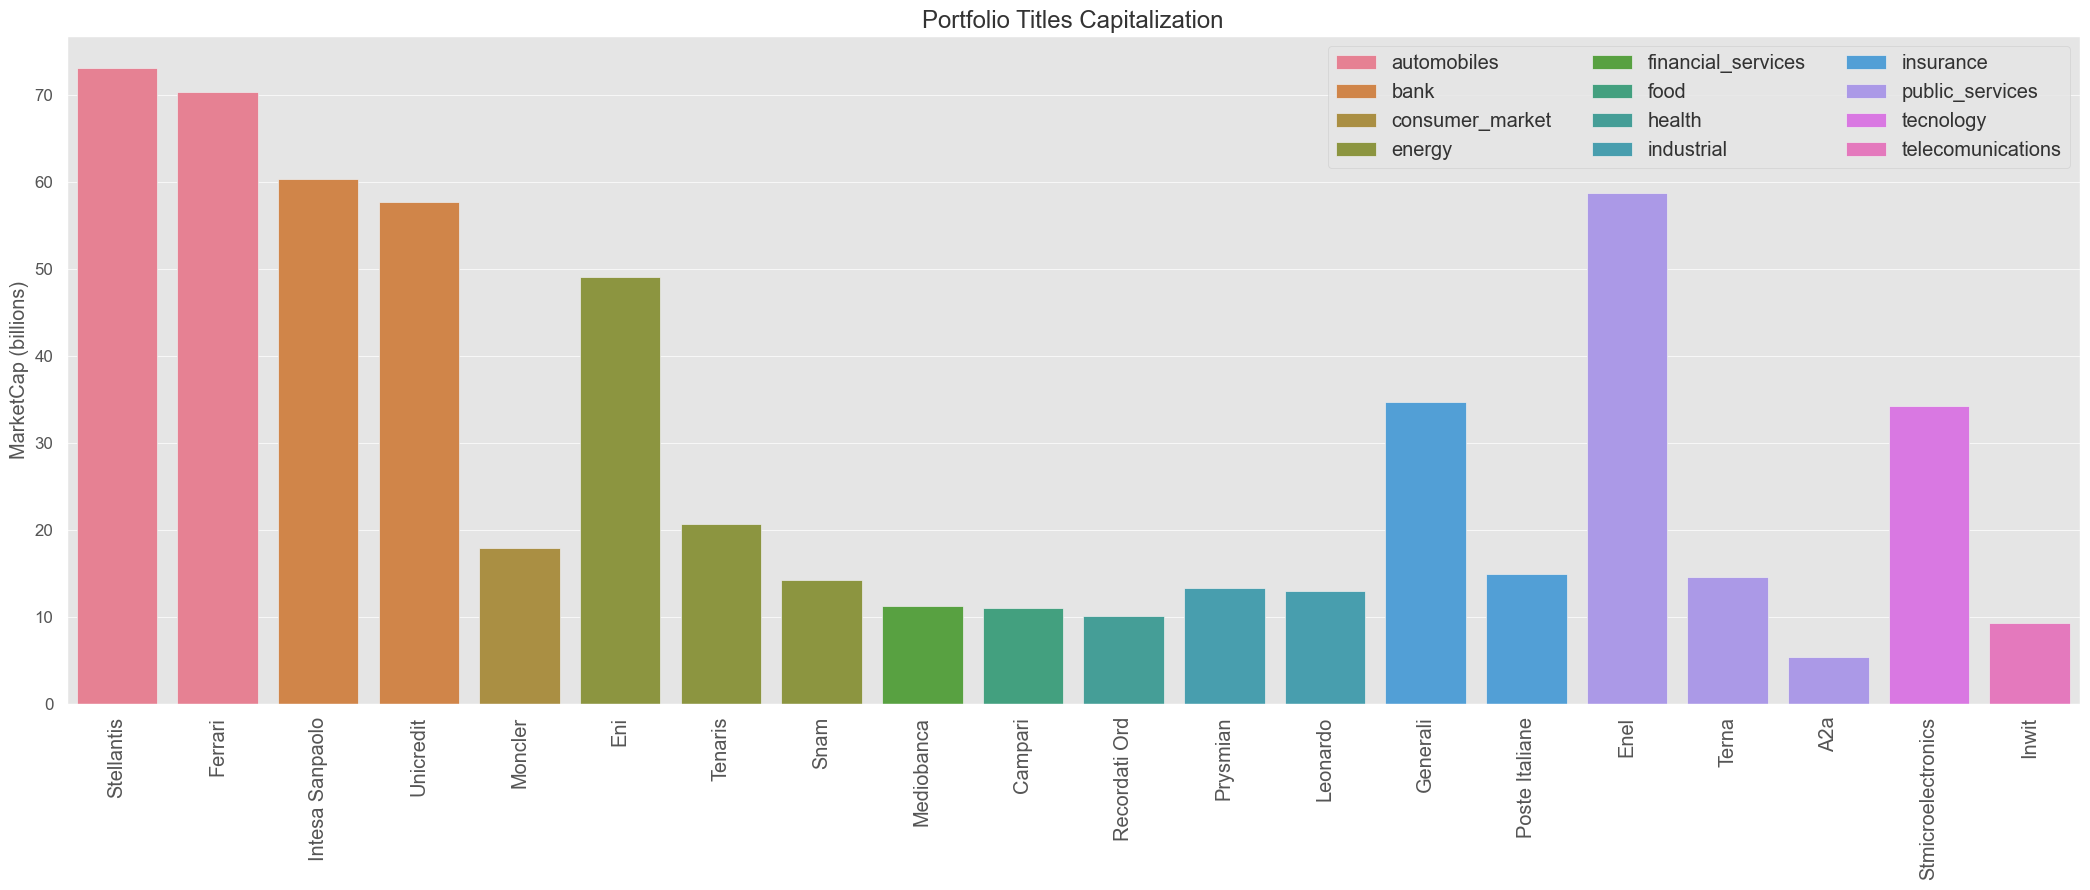

In [3]:
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

sns.barplot(data=data, x="name", y=data["marketCap"]/1_000_000_000, hue="sector", ax=ax)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center', fontsize="x-large")
ax.set_title("Portfolio Titles Capitalization", fontsize="xx-large")
ax.set_xlabel("", fontsize="x-large")
ax.set_ylabel("MarketCap (billions)", fontsize="x-large")
ax.legend(ncols=3, fontsize="x-large")
plt.show()

In [4]:
portfolio_components_returns = utils.compute_returns(returns_data["Adj Close"][list(data["ticker"])])

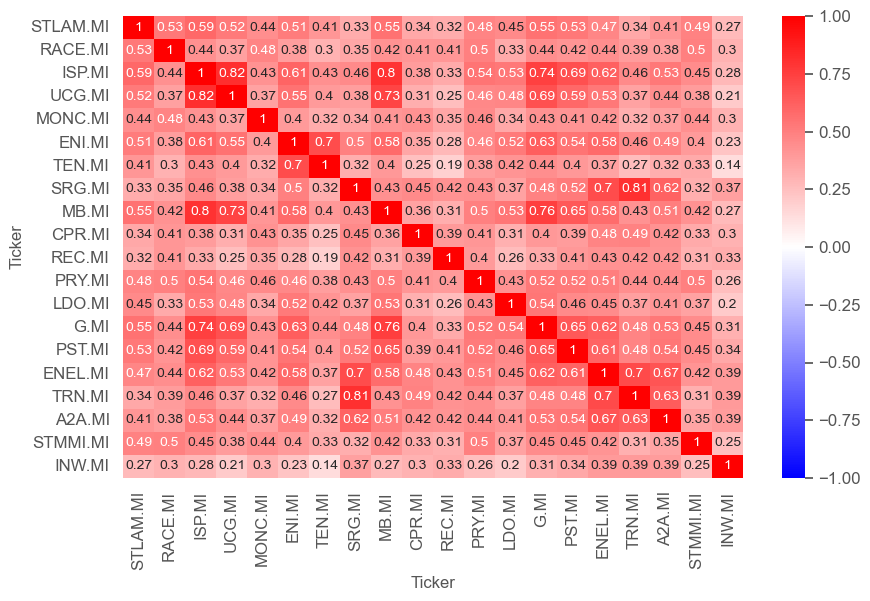

In [5]:
sns.heatmap(portfolio_components_returns.corr(), annot=True, vmin=-1, vmax=1, cmap="bwr")
plt.show()

We notice high correlation. This is not ideal but is a characteristic of the italian exchange.

# Build Strategy

In [6]:
STARTING_CASH = 10_000

n_stocks = len(data)
strategy = data[["ticker", "name", "sector", "previousClose"]].copy()
strategy.loc[:, "shares_to_buy"] = ((STARTING_CASH / n_stocks) / data["previousClose"].values) // 1 
strategy.loc[:, "invested_amount"] = strategy["shares_to_buy"] * strategy["previousClose"]

total_invested = strategy["invested_amount"].sum()
residual_cash = STARTING_CASH - total_invested

In [7]:
print(f"Invested in stocks: {total_invested:.2f}\nResidual Cash: {residual_cash:.2f}")
display(strategy)

Invested in stocks: 9715.15
Residual Cash: 284.85


,ticker,name,sector,previousClose,shares_to_buy,invested_amount
0,STLAM.MI,Stellantis,automobiles,24.295000,20.0,485.900002
1,RACE.MI,Ferrari,automobiles,386.799988,1.0,386.799988
2,ISP.MI,Intesa Sanpaolo,bank,3.249500,153.0,497.173506
3,UCG.MI,Unicredit,bank,33.580002,14.0,470.120026
4,MONC.MI,Moncler,consumer_market,64.440002,7.0,451.080017
5,ENI.MI,Eni,energy,15.198000,32.0,486.335999
6,TEN.MI,Tenaris,energy,17.855000,28.0,499.939987
7,SRG.MI,Snam,energy,4.208000,118.0,496.544022
8,MB.MI,Mediobanca,financial_services,13.400000,37.0,495.799986
9,CPR.MI,Campari,food,8.960000,55.0,492.800002


# Strategy simulation from 2018 *(no rebalancing)*

In [8]:
starting_day = "2018-01-02"
portfolio = strategy.iloc[:, [0, 1, 2]].copy()
portfolio.sort_values(by="ticker", ignore_index=True, inplace=True)
portfolio.set_index("ticker", inplace=True)
display(portfolio.head())

,name,sector
ticker,,
A2A.MI,A2a,public_services
CPR.MI,Campari,food
ENEL.MI,Enel,public_services
ENI.MI,Eni,energy
G.MI,Generali,insurance


In [9]:
portfolio_data = yf.download(tickers=list(portfolio.index), actions=True, start=starting_day)
portfolio_data.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

[*********************100%%**********************]  20 of 20 completed


In [10]:
portfolio_dividends = portfolio_data["Dividends"]
portfolio_close = portfolio_data["Close"]
portfolio_adj_close = portfolio_data["Adj Close"]
portfolio_splits = portfolio_data["Stock Splits"]

In [11]:
portfolio[f"close-{starting_day}"] = portfolio_close.iloc[0, :]
portfolio[f"adj_close-{starting_day}"] = portfolio_adj_close.iloc[0, :]
display(portfolio.head())

,name,sector,close-2018-01-02,adj_close-2018-01-02
ticker,,,,
A2A.MI,A2a,public_services,1.522,1.119308
CPR.MI,Campari,food,6.355,6.118124
ENEL.MI,Enel,public_services,5.105,3.605049
ENI.MI,Eni,energy,13.830,9.367818
G.MI,Generali,insurance,15.020,10.509218


In [12]:
STARTING_CASH = 10_000

n_stocks = len(portfolio)
portfolio["shares_to_buy"] = ((STARTING_CASH / n_stocks) / portfolio[f"close-{starting_day}"].values) // 1 
portfolio["invested_amount"] = portfolio["shares_to_buy"] * portfolio[f"close-{starting_day}"]

total_invested = portfolio["invested_amount"].sum()
residual_cash = STARTING_CASH - total_invested

print(f"Invested in stocks: {total_invested:.2f}\nResidual Cash: {residual_cash:.2f}")
display(portfolio.head())

Invested in stocks: 9840.79
Residual Cash: 159.21


,name,sector,close-2018-01-02,adj_close-2018-01-02,shares_to_buy,invested_amount
ticker,,,,,,
A2A.MI,A2a,public_services,1.522,1.119308,328.0,499.215985
CPR.MI,Campari,food,6.355,6.118124,78.0,495.690001
ENEL.MI,Enel,public_services,5.105,3.605049,97.0,495.185002
ENI.MI,Eni,energy,13.830,9.367818,36.0,497.879997
G.MI,Generali,insurance,15.020,10.509218,33.0,495.660015


In [13]:
portfolio_returns = utils.compute_returns(portfolio_close)
portfolio_cum_ret = (portfolio_returns + 1).cumprod()
portfolio_cum_ret.iloc[0, :] = 1

portfolio_adj_ret = utils.compute_returns(portfolio_adj_close)
portfolio_adj_cum_ret = (portfolio_adj_ret + 1).cumprod()
portfolio_adj_cum_ret.iloc[0, :] = 1

In [14]:
strategy_cum_ret = portfolio_cum_ret.copy()
strategy_adj_cum_ret = portfolio_adj_cum_ret.copy()
for stock in portfolio.index:
    strategy_cum_ret[stock] = strategy_cum_ret[stock] * portfolio.loc[stock, "invested_amount"]
    strategy_adj_cum_ret[stock] = strategy_adj_cum_ret[stock] * portfolio.loc[stock, "invested_amount"]

In [15]:
no_rebalancing_strategy_performance = strategy_cum_ret.sum(axis=1)
no_rebalancing_strategy_adj_performance = strategy_adj_cum_ret.sum(axis=1)

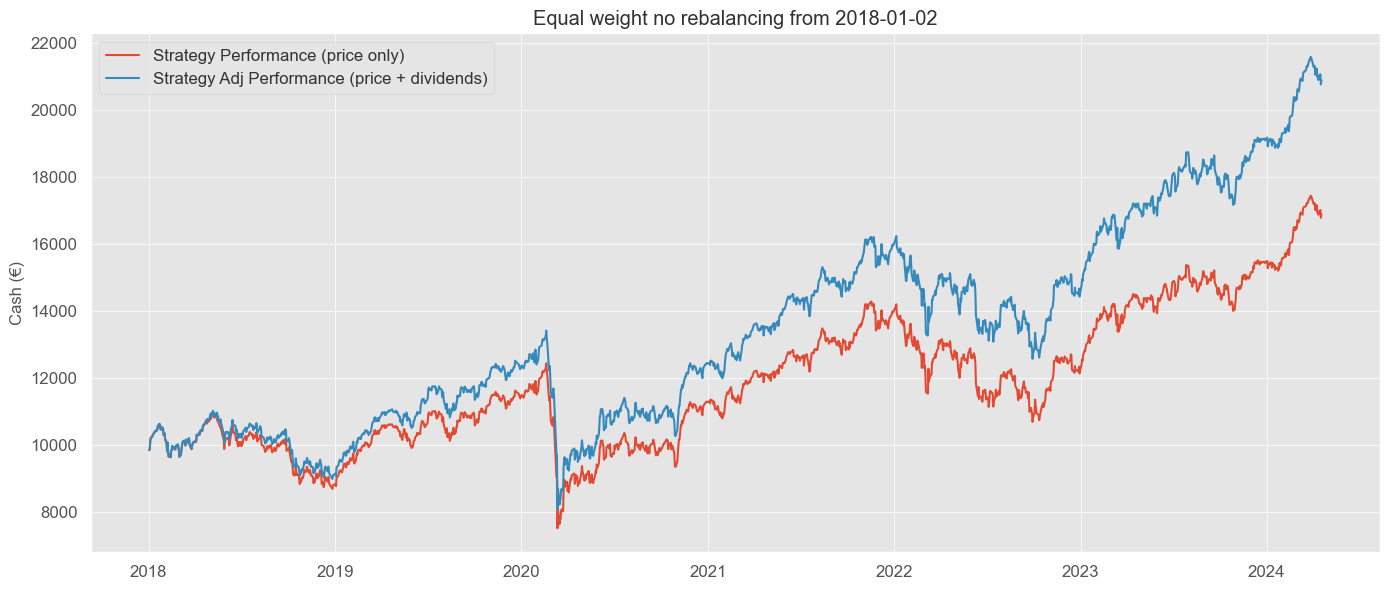

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(no_rebalancing_strategy_performance, label="Strategy Performance (price only)")
ax.plot(no_rebalancing_strategy_adj_performance, label="Strategy Adj Performance (price + dividends)")
ax.legend()
ax.set_ylabel("Cash (€)")
ax.set_title("Equal weight no rebalancing from " + starting_day)
plt.show()

# Strategy simulation with rebalancing

In [17]:
def get_number_of_shares_to_buy(date: str, capital: float, portfolio_data: pd.DataFrame):
    n_stocks = len(portfolio_data["Close"].columns)
    return  ((capital / n_stocks) / portfolio_data["Close"].loc[date:].iloc[0]) // 1 

def period_change(frequency: str, current_day: pd.Timestamp, next_day: pd.Timestamp) -> bool:
    assert frequency in ["year", "month", "day", "never"]
    if frequency == "year":
        return current_day.year != next_day.year
    if frequency == "month":
        return current_day.month != next_day.month
    if frequency == "day":
        return current_day.day != next_day.day
    if frequency == "never":
        return False

In [18]:
def rebalance_strategy(rebalance_frequency: str, portfolio_data: pd.DataFrame, starting_cash: float):  
    stocks = list(portfolio_data["Adj Close"].columns)
    n_stocks = len(stocks)
    days = portfolio_data.index
    
    #Initialize series to keep track cash
    available_money = pd.Series(index=days)
    
    # Compute stock adj returns
    portfolio_adj_ret = utils.compute_returns(portfolio_data["Adj Close"])
    
    # Initialize empty DataFrame
    portfolio_cum_ret = pd.DataFrame(index=days, columns=stocks)
    
    # Add first row
    row = portfolio_data["Close"].loc[days[0]:].iloc[0] * get_number_of_shares_to_buy(days[0], starting_cash, portfolio_data)
    portfolio_cum_ret.loc[days[0], :] = row
    
    # Update available money
    available_money.loc[days[0]] = starting_cash - row.sum()
    
    current_day = days[0]

    for day in tqdm(days[1:]):
        # Compute returns
        stock_returns = portfolio_adj_ret.loc[day]
        portfolio_cum_ret.loc[day, :] = portfolio_cum_ret.loc[current_day, :] * (stock_returns + 1)
        available_money.loc[day] = available_money.loc[current_day]
        
        # Handle period change
        if period_change(rebalance_frequency, current_day, day):
            # Sell all stocks
            available_money.loc[day] = available_money.loc[current_day] + portfolio_cum_ret.loc[day].sum()
            # Buy with equal weight
            row = portfolio_data["Close"].loc[day:].iloc[0] * get_number_of_shares_to_buy(day, available_money[day], portfolio_data)
            portfolio_cum_ret.loc[day, :] = row
            available_money[day] = available_money[day] - (row.sum())
            
        # Change current day
        current_day = day
    return portfolio_cum_ret, available_money

In [19]:
portfolio_data = yf.download(tickers=list(portfolio.index), actions=False, start=starting_day)
portfolio_data.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

[*********************100%%**********************]  20 of 20 completed


In [20]:
yearly_rebalance_portfolio_cum_ret, _ = rebalance_strategy("year", portfolio_data, STARTING_CASH)
monthly_rebalance_portfolio_cum_ret, _ = rebalance_strategy("month", portfolio_data, STARTING_CASH)
daily_rebalance_portfolio_cum_ret, _ = rebalance_strategy("day", portfolio_data, STARTING_CASH)

100%|██████████| 1599/1599 [00:05<00:00, 288.35it/s]


In [21]:
monthly_rebalance_strategy_performance = monthly_rebalance_portfolio_cum_ret.sum(axis=1)
yearly_rebalance_strategy_performance = yearly_rebalance_portfolio_cum_ret.sum(axis=1)
daily_rebalance_strategy_performance = daily_rebalance_portfolio_cum_ret.sum(axis=1)

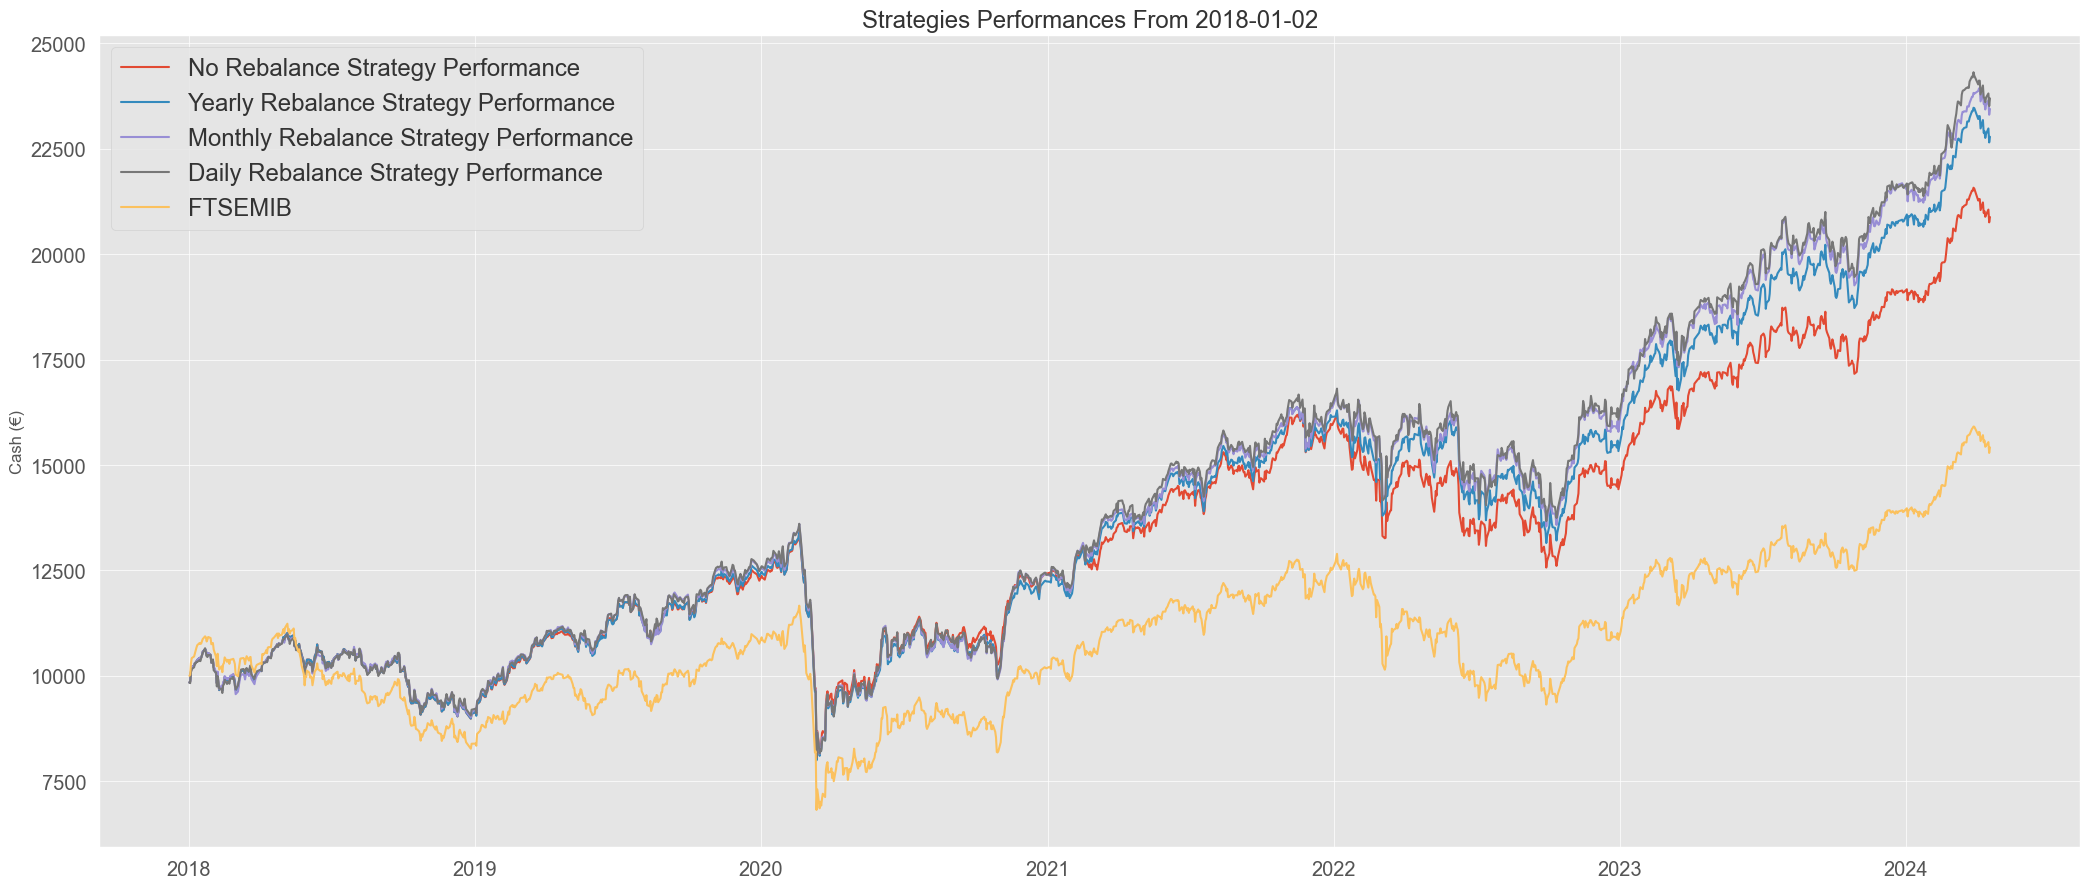

In [22]:
ftsemib = yf.download(tickers="FTSEMIB.MI", progress=False)["Adj Close"].loc["2018":]
benchmark = (ftsemib / ftsemib.iloc[0]) * STARTING_CASH

fig, ax = plt.subplots(figsize=(21, 9), tight_layout=True)
ax.plot(no_rebalancing_strategy_adj_performance, label="No Rebalance Strategy Performance")
ax.plot(yearly_rebalance_strategy_performance, label="Yearly Rebalance Strategy Performance")
ax.plot(monthly_rebalance_strategy_performance, label="Monthly Rebalance Strategy Performance")
ax.plot(daily_rebalance_strategy_performance, label="Daily Rebalance Strategy Performance")
ax.plot(benchmark, label="FTSEMIB")
ax.tick_params(axis='both', which='major', labelsize="x-large")

ax.legend(fontsize="xx-large")
ax.set_ylabel("Cash (€)")
ax.set_title("Strategies Performances From " + starting_day, fontsize="xx-large")
plt.show()